In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import scipy
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.stats import pearsonr

In [2]:
map_genre = {
    "Humor/Family": "Humor/Family/Romance",
    "Self-Help": "Self-Help",
    "Suspense/Mystery": "Suspense/Mystery",
    "Fantasy/Adventure": "Fantasy/Adventure",
    "Biography/Historical": "Biography/Historical/Memoir",
    "Romance": "Humor/Family/Romance",
    "Horror/Thriller": "Horror/Thriller",
    "Memoir": "Biography/Historical/Memoir",
    "Poetry/Novel": "Miscellaneous",
    "Historical/Fiction": "Biography/Historical/Memoir",
    "Novel": "Miscellaneous",
    "Non-Fiction": "Miscellaneous",
    "Folklore": "Fantasy/Adventure",
    "Travel": "Biography/Historical/Memoir",
    "Adventure": "Fantasy/Adventure",
    "Novel/Feminism": "Miscellaneous",
    "Historical/Family": "Biography/Historical/Memoir",
    "Children's/Humor": "Humor/Family/Romance",
    "Magical Realism/Historical": "Biography/Historical/Memoir",
    "Fantasy/Horror": "Fantasy/Adventure",
    "Political/Dystopian": "Fantasy/Adventure",
    "Self-help/Management": "Self-Help",
    "Historical/Adventure": "Fantasy/Adventure",
    "Thriller/Suspense": "Suspense/Mystery",
    "War/Romance": "Miscellaneous",
    "Science fiction/Adventure": "Fantasy/Adventure",
    "Literary fiction/Humor": "Humor/Family/Romance",
    "Adventure/Travel": "Biography/Historical/Memoir",
    "Philosophy/Nature": "Miscellaneous",
    "Satirical/War": "Miscellaneous",
    "Existential/Philosophical": "Miscellaneous",
    "Fantasy/Humor": "Fantasy/Adventure",
    "Mystery/Suspense": "Suspense/Mystery",
    "Thriller/Adventure": "Fantasy/Adventure",
    "Family/Humor": "Humor/Family/Romance",
    "Adventure/Fantasy": "Fantasy/Adventure",
    "Science Fiction/Thriller": "Fantasy/Adventure",
    "Science Fiction/Adventure": "Fantasy/Adventure",
    "Fantasy/Romance": "Fantasy/Adventure",
    "Science Fiction/Humor": "Fantasy/Adventure",
    "Thriller/Mystery": "Suspense/Mystery",
    "Horror/Suspense": "Horror/Thriller",
    "Non-fiction": "Miscellaneous",
    "Fiction": "Miscellaneous",
    "Non-fiction/Historical": "Biography/Historical/Memoir",
    "Philosophy": "Miscellaneous",
    "Cookbook": "Miscellaneous"
}

In [3]:
bookdataset =  pd.read_csv('BookDataset.csv')

for key, value in map_genre.items():
    bookdataset.loc[bookdataset["final genre"] == key, "final genre"] = value

In [4]:
def create_regression_plot(X, Y, Y_pred, x_label, y_label, axs):
    axs.scatter(X, Y, color="blue")
    axs.plot(X, Y_pred, color="red", linewidth=2)
    axs.ticklabel_format(style='plain', axis='y', scilimits=(0, 0))
    axs.ticklabel_format(style='sci', axis='x',scilimits=(0, 0))
    axs.set_xlabel(x_label)
    axs.set_ylabel(y_label)

def calc_mean_std_dev(ratings):
    ratings_mean = (np.sum(np.array([5, 4, 3, 2, 1]) * ratings, axis=1)/np.sum(ratings, axis=1)).to_numpy().reshape(-1,1)
    ratings_squared_mean = (np.sum((np.array([5, 4, 3, 2, 1]) ** 2) * ratings, axis=1)/np.sum(ratings, axis=1)).to_numpy().reshape(-1,1)
    ratings_std_dev = np.sqrt(ratings_squared_mean - (ratings_mean ** 2))
    return ratings_mean, ratings_std_dev

def perform_regression_analysis(X, Y):

    ## Now we perform linear regression and plot it:
    r_model = linear_model.LinearRegression()

    ## Train the model to see the relation
    r_model.fit(X, Y)

    ## Predict the number of reviews
    predict_reviews_nums = r_model.predict(X)

    ## Mean square error
    print("Mean squared error: %.2f" % mean_squared_error(Y, predict_reviews_nums))

    ## r2_score
    print("R2 score: %.2f" % r2_score(Y, predict_reviews_nums))

    # Pearson correlation
    pearson_coef, p_value = pearsonr(X.flatten(), Y.flatten())
    print("Pearson correlation: %.4f" % pearson_coef)
    print("P-value: %.4f" % p_value)
    
    ## Weight of linear regression
    m = r_model.coef_
    ## Intersept of the line
    c = r_model.intercept_

    return predict_reviews_nums

def calc_std_deviation(ratings, number_of_ratings):
    ratings = ratings.to_numpy().astype('float64')
    ## Probability of ratings is each rating divided by total ratings
    probability_ratings = ratings/number_of_ratings
    
    ## We now do \sum_{1}^{5} Xp(x)
    x = np.array([5,4,3,2,1], dtype=float)
    x = x.reshape(1,5)
    weighted_x = x * probability_ratings
    expected_values = np.sum(weighted_x, axis=1, keepdims=True)
    
    ##Variance Calculation
    diff_ratings = x - expected_values
    diff_ratings_squared = diff_ratings**2

    weighted_diff_squared = diff_ratings_squared * probability_ratings
    variance_ratings = np.sum(weighted_diff_squared, axis=1)
    
    stddev_ratings = np.sqrt(variance_ratings)


    stddev_ratings = stddev_ratings.reshape(-1,1)
    return stddev_ratings

In [5]:
# bookdataset =  pd.read_csv('BookDataset.csv')

ratings = bookdataset[['RatingDist5', 'RatingDist4', 'RatingDist3', 'RatingDist2',
       'RatingDist1']]
number_of_ratings = bookdataset[['RatingDistTotal']].to_numpy().reshape(-1,1)

## Perform regression analysis by taking standard deviation of ratings as "Controversy Score"
def do_std_dev_analysis(ratings, number_of_ratings, regress_y, plot_axs, plot_enable=False, ylabel = "Number of ratings -->"):
    ## Number of ratings are required for standard deviation calculation. Thus, we have separate regress_y variable.
    ratings_std_dev = calc_std_deviation(ratings, number_of_ratings)
    predictions = perform_regression_analysis(ratings_std_dev, regress_y)
    
    if(plot_enable):
        create_regression_plot(ratings_std_dev, regress_y, predictions, "Standard deviation of ratings -->", ylabel, plot_axs)

## Perform regression analysis by taking difference between mean and median of ratings as "Controversy Score"  
def do_mean_median_analysis(ratings, number_of_ratings, plot_axs, plot_enable=False, ylabel = "Number of ratings -->"):
    median_index = number_of_ratings.reshape(-1) // 2
    cum_ratings = np.cumsum(ratings, axis=1).to_numpy()
    ratings_median = np.zeros_like(median_index)

    for i in range(ratings.shape[0]):
        for j in range(5):
            if(cum_ratings[i, j] >= median_index[i]):
                ratings_median[i] = 5 - j
                break
    
    ratings_median = ratings_median.reshape(-1,1)
    ratings_mean = calc_mean_std_dev(ratings)[0]
    #ratings_mean = np.mean(ratings, axis=1).to_numpy().reshape(-1,1)

    ratings_diff = abs(ratings_median - ratings_mean)

    predictions = perform_regression_analysis(ratings_diff, number_of_ratings)
    
    if(plot_enable):
        create_regression_plot(ratings_diff, number_of_ratings, predictions,"||Mean - Median|| -->", ylabel, plot_axs);


## Perform regression analysis by taking ratio of 5 star to 1 star as "Controversy Score"
def do_ratio_analysis(ratings, number_of_ratings, plot_axs, plot_enable=False, ylabel = "Number of ratings -->"):
    ratings_np = ratings.to_numpy()
    ratio_5_1 = (ratings_np[:,0] / ratings_np[:,4]).reshape(-1, 1)
    predictions = perform_regression_analysis(ratio_5_1, number_of_ratings)
    
    if(plot_enable):
        create_regression_plot(ratio_5_1, number_of_ratings, predictions, "Ratio of 5star to 1star -->", ylabel, plot_axs)


Mean squared error: 0.02
R2 score: 0.56
Pearson correlation: -0.7509
P-value: 0.0000


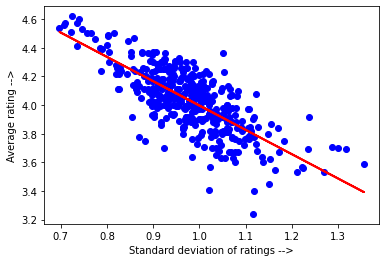

In [6]:
fig, axs = plt.subplots()
regress_y = bookdataset[['Rating']].to_numpy().reshape(-1,1)
do_std_dev_analysis(ratings, number_of_ratings, regress_y,axs, True, "Average rating -->")

Mean squared error: 561802169612.83
R2 score: 0.03
Pearson correlation: 0.1763
P-value: 0.0003


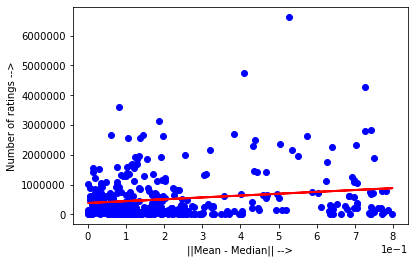

In [7]:
fig, axs = plt.subplots()
do_mean_median_analysis(ratings, number_of_ratings, axs, True)

Mean squared error: 576395305090.11
R2 score: 0.01
Pearson correlation: 0.0770
P-value: 0.1195


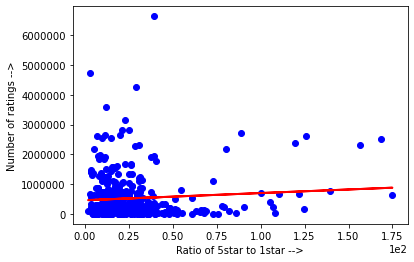

In [8]:
fig, axs = plt.subplots()
do_ratio_analysis(ratings, number_of_ratings, axs, True)

HUMOR/FAMILY/ROMANCE
Mean squared error: 0.03
R2 score: 0.24
Pearson correlation: -0.4898
P-value: 0.0000

SELF-HELP
Mean squared error: 0.01
R2 score: 0.68
Pearson correlation: -0.8259
P-value: 0.0000

SUSPENSE/MYSTERY
Mean squared error: 0.01
R2 score: 0.72
Pearson correlation: -0.8462
P-value: 0.0000

FANTASY/ADVENTURE
Mean squared error: 0.01
R2 score: 0.76
Pearson correlation: -0.8739
P-value: 0.0000

BIOGRAPHY/HISTORICAL/MEMOIR
Mean squared error: 0.02
R2 score: 0.58
Pearson correlation: -0.7597
P-value: 0.0000

HORROR/THRILLER
Mean squared error: 0.01
R2 score: 0.57
Pearson correlation: -0.7579
P-value: 0.0007

MISCELLANEOUS
Mean squared error: 0.03
R2 score: 0.34
Pearson correlation: -0.5846
P-value: 0.0000



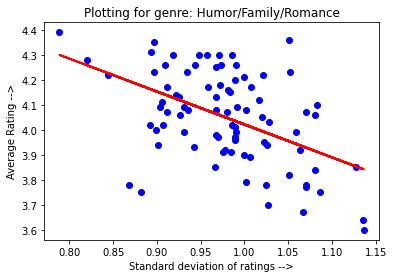

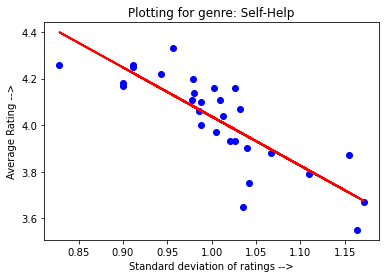

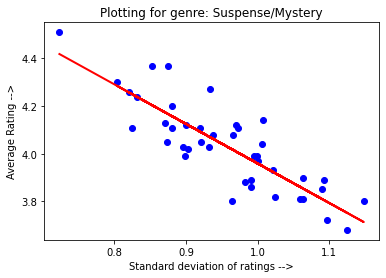

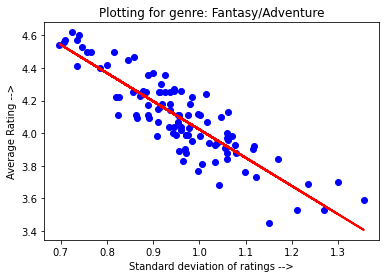

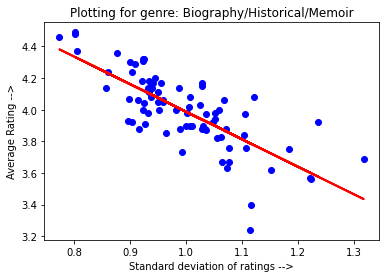

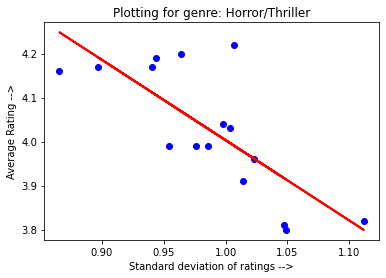

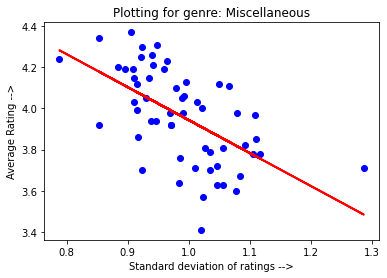

In [9]:
## Per genre analysis. We only plot std-deviation as it gives best relations

unique_values = bookdataset["final genre"].unique()

# fig, axs = plt.subplots(7,1)
count = 0
for genre in unique_values:
    dataSubset = bookdataset.loc[bookdataset["final genre"] == genre]
    ratings_subset = dataSubset[['RatingDist5', 'RatingDist4', 'RatingDist3', 'RatingDist2',
       'RatingDist1']]
    number_of_ratings_subset = dataSubset[['RatingDistTotal']].to_numpy().reshape(-1,1)
    regress_y = dataSubset[['Rating']].to_numpy().reshape(-1,1)
    
    string_print = "Plotting for genre: " + str(genre)
    fig, axs = plt.subplots()
    axs.set_title(string_print)
    print(genre.upper())
    do_std_dev_analysis(ratings_subset, number_of_ratings_subset, regress_y, axs, True, "Average Rating -->")
    print()
    

HUMOR/FAMILY/ROMANCE
Mean squared error: 263489683712.72
R2 score: 0.07
Pearson correlation: 0.2705
P-value: 0.0128

SELF-HELP
Mean squared error: 135251942832.85
R2 score: 0.06
Pearson correlation: 0.2395
P-value: 0.2109

SUSPENSE/MYSTERY
Mean squared error: 754822795981.70
R2 score: 0.18
Pearson correlation: 0.4204
P-value: 0.0056

FANTASY/ADVENTURE
Mean squared error: 1016569618117.93
R2 score: 0.00
Pearson correlation: 0.0138
P-value: 0.8910

BIOGRAPHY/HISTORICAL/MEMOIR
Mean squared error: 461629351683.65
R2 score: 0.00
Pearson correlation: 0.0224
P-value: 0.8427

HORROR/THRILLER
Mean squared error: 105199368495.08
R2 score: 0.16
Pearson correlation: 0.4046
P-value: 0.1201

MISCELLANEOUS
Mean squared error: 222857938214.55
R2 score: 0.00
Pearson correlation: -0.0292
P-value: 0.8292



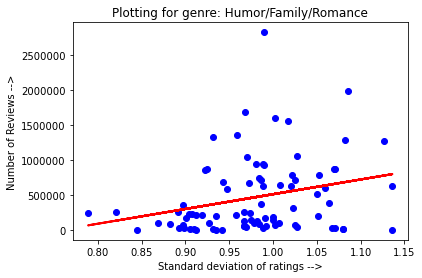

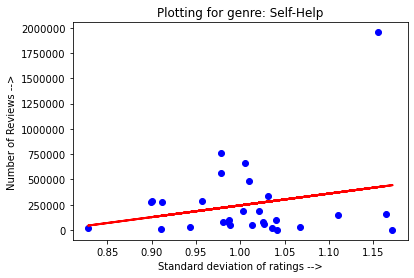

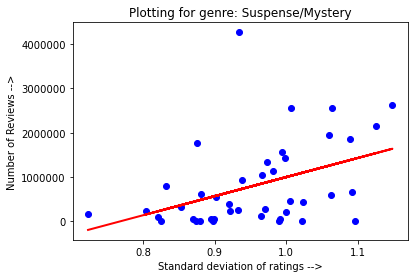

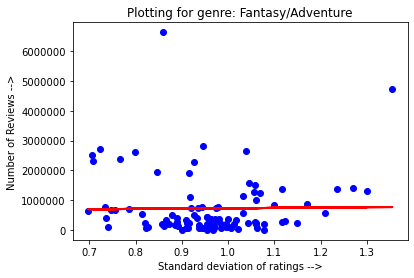

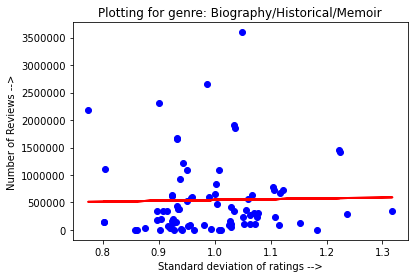

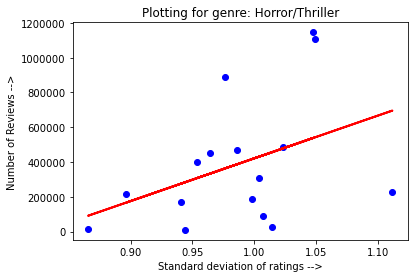

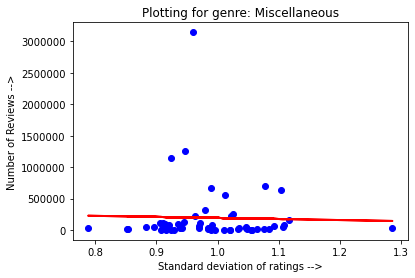

In [10]:
for genre in unique_values:
    dataSubset = bookdataset.loc[bookdataset["final genre"] == genre]
    ratings_subset = dataSubset[['RatingDist5', 'RatingDist4', 'RatingDist3', 'RatingDist2',
       'RatingDist1']]
    number_of_ratings_subset = dataSubset[['RatingDistTotal']].to_numpy().reshape(-1,1)
    
    string_print = "Plotting for genre: " + str(genre)
    fig, axs = plt.subplots()
    axs.set_title(string_print)
    print(genre.upper())
    do_std_dev_analysis(ratings_subset, number_of_ratings_subset, number_of_ratings_subset,axs, True, "Number of Reviews -->")
    print()

HUMOR/FAMILY/ROMANCE
Mean squared error: 263489683712.72
R2 score: 0.07
Pearson correlation: 0.2705
P-value: 0.0128

SELF-HELP
Mean squared error: 135251942832.85
R2 score: 0.06
Pearson correlation: 0.2395
P-value: 0.2109

SUSPENSE/MYSTERY
Mean squared error: 754822795981.70
R2 score: 0.18
Pearson correlation: 0.4204
P-value: 0.0056

FANTASY/ADVENTURE
Mean squared error: 1016569618117.93
R2 score: 0.00
Pearson correlation: 0.0138
P-value: 0.8910

BIOGRAPHY/HISTORICAL/MEMOIR
Mean squared error: 461629351683.65
R2 score: 0.00
Pearson correlation: 0.0224
P-value: 0.8427

HORROR/THRILLER
Mean squared error: 105199368495.08
R2 score: 0.16
Pearson correlation: 0.4046
P-value: 0.1201

MISCELLANEOUS
Mean squared error: 222857938214.55
R2 score: 0.00
Pearson correlation: -0.0292
P-value: 0.8292



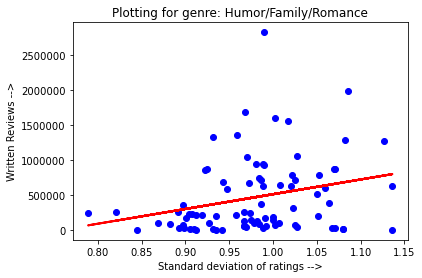

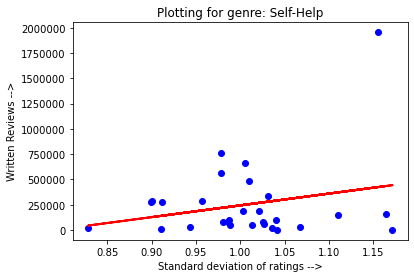

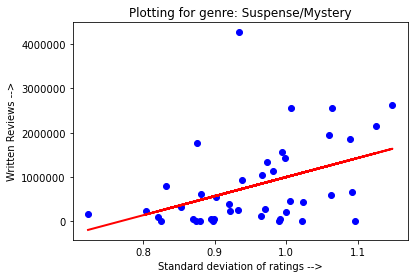

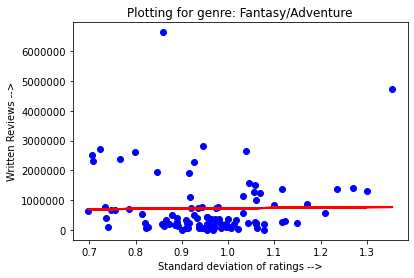

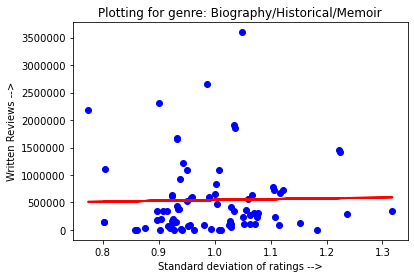

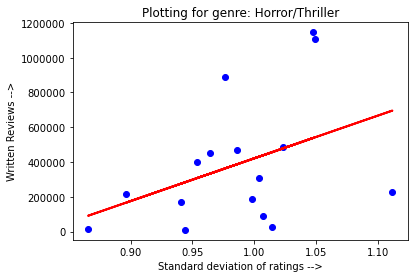

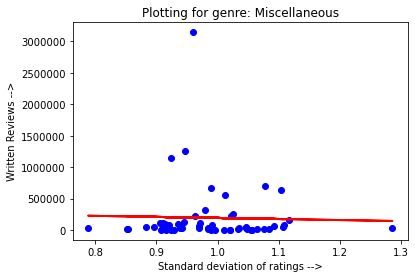

In [11]:
for genre in unique_values:
    dataSubset = bookdataset.loc[bookdataset["final genre"] == genre]
    ratings_subset = dataSubset[['RatingDist5', 'RatingDist4', 'RatingDist3', 'RatingDist2',
       'RatingDist1']]
    number_of_ratings_subset = dataSubset[['RatingDistTotal']].to_numpy().reshape(-1,1)
    regress_y = dataSubset[['CountsOfReview']].to_numpy().reshape(-1,1)
    string_print = "Plotting for genre: " + str(genre)
    fig, axs = plt.subplots()
    axs.set_title(string_print)
    print(genre.upper())
    do_std_dev_analysis(ratings_subset, number_of_ratings_subset, number_of_ratings_subset,axs, True, "Written Reviews -->")
    print()
    #do_ratio_analysis(ratings_subset, number_of_ratings_subset, axs, True)
    #do_mean_median_analysis(ratings_subset, number_of_ratings_subset, axs, True)
    